<a href="https://colab.research.google.com/github/mobkimark/Hamoye/blob/main/Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
##import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm

In [27]:
!ls /content/sample_data

anscombe.json		      mnist_test.csv	     sample_submission_v2.csv
california_housing_test.csv   mnist_train_small.csv  test_v2_file_mapping.csv
california_housing_train.csv  README.md		     train_v2.csv


In [28]:
path = "/content/sample_data"
train_path = os.path.join(path, "train-jpg")
test_path = os.path.join(path, "test-jpg")
class_path = os.path.join(path, "/content/sample_data/train_v2.csv")
submission_path = os.path.join(path, "/content/sample_data/sample_submission_v2.csv")

In [29]:
#reading the labels
df = pd.read_csv(class_path)
submission_df = pd.read_csv(submission_path)

print(df.shape)
print(submission_df.shape)

(40479, 2)
(61191, 2)


In [30]:
label_list = []
for tag_split in df.tags.to_numpy():
    labels = tag_split.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [31]:
print(len(label_list))

17


In [32]:
labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [33]:
# One-hot encode the features
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split() else 0)

df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


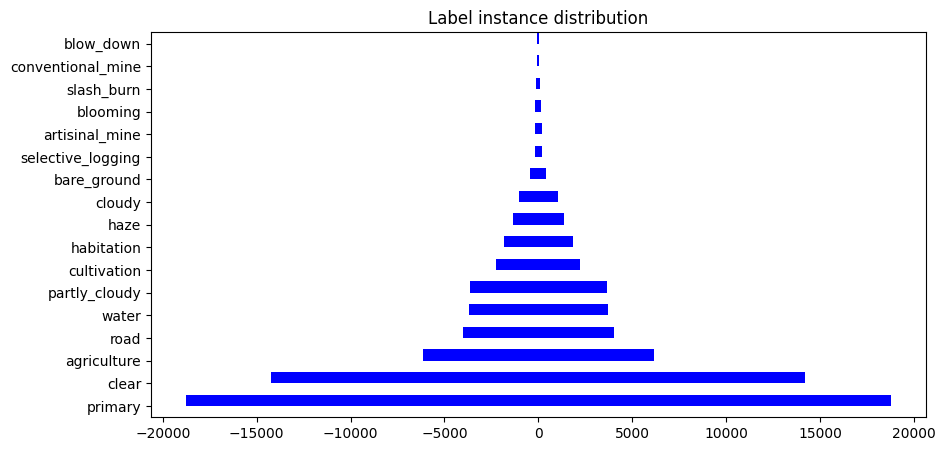

In [34]:
# plot the labels
df[label_list].sum().sort_values(ascending=False)\
.plot(kind='barh', title='Label instance distribution', orientation= 'vertical', figsize=(10, 5), color='blue')
plt.show()

In [35]:
import gc
gc.collect()

5506

In [36]:
# for the analysis we need columns after tag and image_name
df_columns = list(df.columns[2:])
# print(df_columns,end='')

In [37]:
# Onehot encode the image name
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')
df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
import gc
gc.collect()

0

In [39]:
def f_beta_score(y_true, y_pred, beta = 2, epsilon = 1e-4):

    beta_squared = beta**2

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)

    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)


In [40]:
def accuracy_score(y_true, y_pred, epsilon = 1e-4):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp

    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32),
                       axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [41]:
import gc
gc.collect()

0

In [42]:
##Split training data to training and validation sets
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                              directory = train_path,
                                              x_col="image_name",
                                              y_col=df_columns,
                                              subset="training",
                                              batch_size=128,
                                              seed=42,
                                              shuffle = True,
                                              class_mode="raw",
                                              target_size=(128,128))


# val_set contains 20 percent of images
val_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                            directory = train_path,
                                            x_col="image_name",
                                            y_col=df_columns,
                                            subset="validation",
                                            batch_size=128,
                                            seed=42,
                                            shuffle = True,
                                            class_mode="raw",
                                            target_size=(128,128))

Found 0 validated image filenames.
Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 40479 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 40479 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [43]:
##Building a sequential feed forward network in keras
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    return model


In [44]:
model = model_building()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 128, 128, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        1

In [45]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f_beta_score, accuracy_score])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [46]:
# Batchsize for training and validation set
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [47]:
import gc
gc.collect()

162

In [48]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[callback])

ValueError: ignored

In [ ]:
import gc
gc.collect()

In [ ]:
##visualize the images
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Test data: divide the submission dataframe into two splits as the image names after 40669 is different
test_df = submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

In [ ]:
test_df['image_name'] = submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_df.head()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory = test_path,
                                            x_col="image_name",
                                            y_col=None,
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

In [ ]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

In [ ]:
test_names = test_gen.filenames

test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

In [ ]:
# additional batch of the test dataset
additional_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)

In [ ]:
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

In [ ]:
additional_gen = test_datagen.flow_from_dataframe(dataframe=additional_df,
                                                  directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional",
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=(128, 128))


additional_step = additional_gen.n // additional_gen.batch_size

In [ ]:
# predicted probabilities for each class
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

In [ ]:
additional_names = additional_gen.filenames

additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

In [ ]:
final_result = pd.concat([test_result_df, additional_result_df])

final_result = final_result.reset_index().drop('index', axis =1)

final_result

In [ ]:
# Remove the .jpg extension from the image_name of the final_result
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result

In [ ]:
# save the results to a CSV file save and set the index to false.
final_result.to_csv('submission.csv', index=False)